In [1]:
import numpy as np
import pandas as pd

import RW
import NRLMF

import math
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score

In [2]:
rna_sim=pd.read_csv('rna_similarity.txt',sep='\t')
prot_sim=pd.read_csv('prot_similarity.txt',sep='\t')
inter=pd.read_csv('list_of_interactions.txt',sep='\t')

rna_cnt=inter['RNA_ID'].unique().shape[0] # m
prot_cnt=inter['PROT_ID'].unique().shape[0] # n

Sl=np.empty((rna_cnt,rna_cnt))
Sp=np.empty((prot_cnt,prot_cnt))

for i in rna_sim.index:
    Sl[rna_sim['RNA(i)'][i]][rna_sim['RNA(j)'][i]]=rna_sim['Sim(i,j)'][i]

for i in prot_sim.index:
    Sp[prot_sim['PROT(i)'][i]][prot_sim['PROT(j)'][i]]=prot_sim['Sim(i,j)'][i]

Y=np.zeros((rna_cnt,prot_cnt))
for i in inter.index:
    Y[inter['RNA_ID'][i]][inter['PROT_ID'][i]]=1


In [4]:
# # run once
# random_grouping=np.random.choice(rna_cnt*prot_cnt,size=rna_cnt*prot_cnt,replace=False)
# random_grouping=np.reshape(random_grouping,(10,np.int64(rna_cnt*prot_cnt/10)))
# print(random_grouping)
# np.savetxt('IRWNRLMF_CVS3.txt',random_grouping,fmt='%1d')
random_grouping=np.loadtxt('IRWNRLMF_CVS3.txt',dtype=np.int64)
print(random_grouping)

[[63093 10185 29979 ... 12068 19502 50611]
 [ 5152  5862 24746 ... 43658  9457 35862]
 [ 5629  8544  2621 ... 55127 44128  1553]
 ...
 [10735 20146 61690 ... 22683 49145 16517]
 [51743 53969 49152 ... 57560 56158 53785]
 [28365  6088 47351 ... 52526 63282 19557]]


In [5]:
def update_metrics(y_true,y_pred,tpr_arr,fpr_arr,pre_arr,ds_no):
    data ={'isTrue': y_true, 'Prob': y_pred}
    df=pd.DataFrame(data)
    df.sort_values(by=['Prob'],ascending=False,inplace=True)
    pos=len([i for i in range(len(y_true)) if y_true[i]==True])
    fal=len(y_true)-pos
    thresholds = np.linspace(0,1,500)
    tpr=[]
    fpr=[]
    pre=[]
    for th in thresholds:
        tp=0
        fp=0
        for i in df.index:
            if df['Prob'][i]<th:
                break
            if df['isTrue'][i]==1:
                tp+=1
            else:
                fp+=1
        tpr.append(tp/pos)
        fpr.append(fp/fal)
        if tp+fp!=0:
            pre.append(tp/(tp+fp))
        else:
            pre.append(1)
    tpr_arr.append(tpr)
    fpr_arr.append(fpr)
    pre_arr.append(pre)


+++ IRWNRLMF CVS-3: Dataset-0 +++
Negative RNA set=
[110, 163, 258, 262, 357]
Negative protein set=
[]
Iteration count=9465
AUROC=0.929473243924402
AUPR=0.6689702378260414
+++ IRWNRLMF CVS-3: Dataset-1 +++
Negative RNA set=
[298, 301, 469, 753, 851, 961]
Negative protein set=
[]
Iteration count=11925
AUROC=0.9388236053719008
AUPR=0.6922197805946584
+++ IRWNRLMF CVS-3: Dataset-2 +++
Negative RNA set=
[341, 402, 468, 808]
Negative protein set=
[]
Iteration count=9953
AUROC=0.931377022576488
AUPR=0.6675985932550721
+++ IRWNRLMF CVS-3: Dataset-3 +++
Negative RNA set=
[166, 450, 848]
Negative protein set=
[47]
Iteration count=8658
AUROC=0.9213055803980253
AUPR=0.6715109688284623
+++ IRWNRLMF CVS-3: Dataset-4 +++
Negative RNA set=
[22, 53, 196, 281, 347, 436, 609, 672]
Negative protein set=
[]
Iteration count=8991
AUROC=0.930009433030734
AUPR=0.6715886336114609
+++ IRWNRLMF CVS-3: Dataset-5 +++
Negative RNA set=
[555, 616, 934]
Negative protein set=
[49]
Iteration count=8946
AUROC=0.92693048

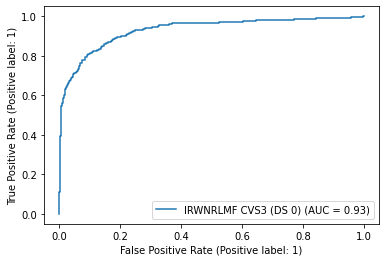

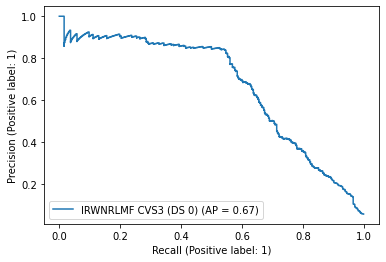

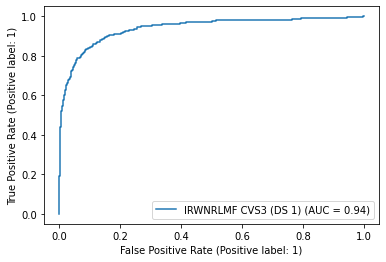

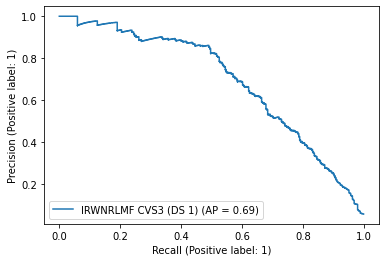

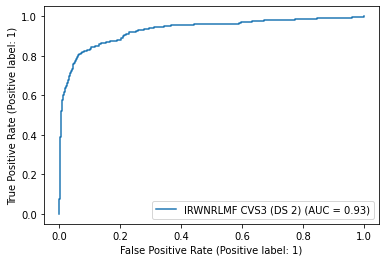

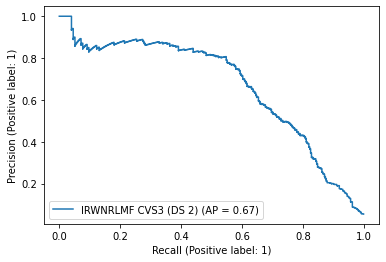

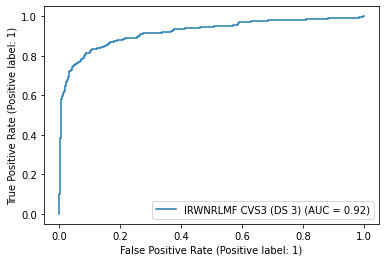

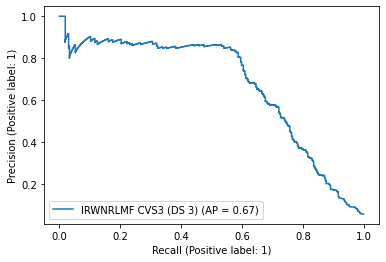

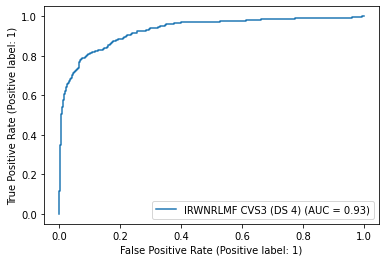

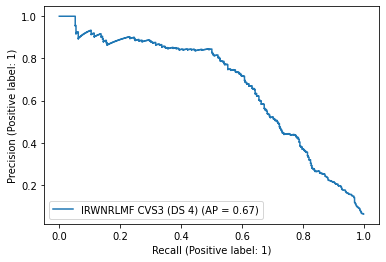

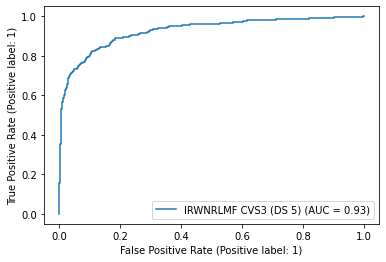

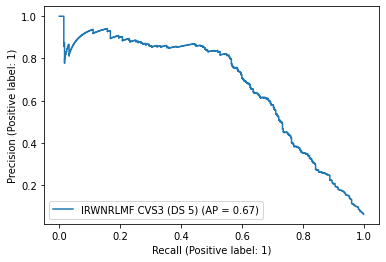

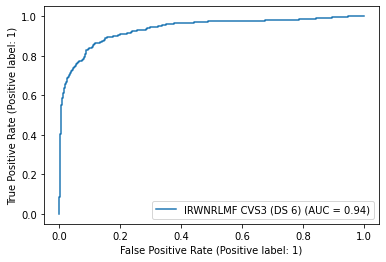

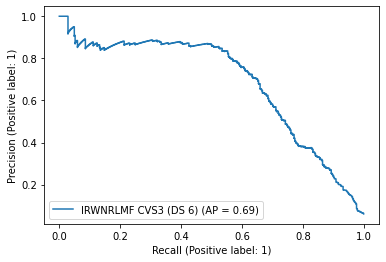

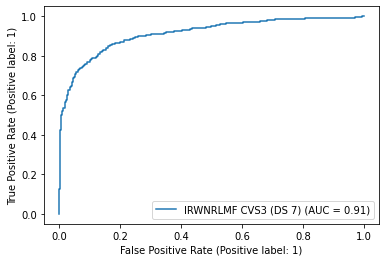

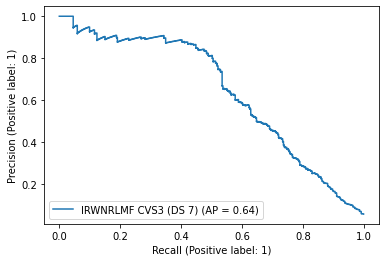

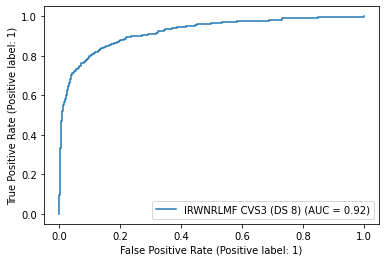

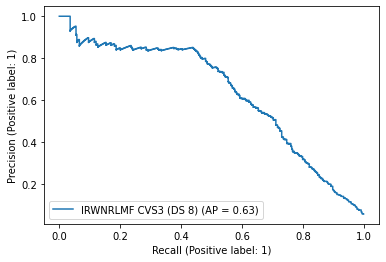

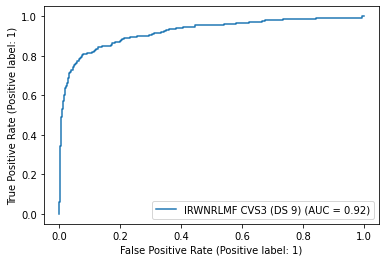

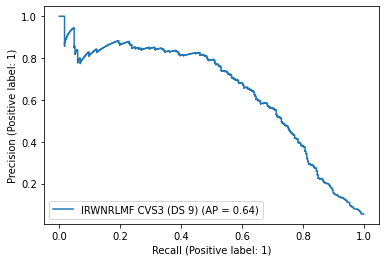

In [6]:
avg_auroc=0
avg_aupr=0
tpr_arr=[]
fpr_arr=[]
pre_arr=[]

for i in range(10):
    print(f'+++ IRWNRLMF CVS-3: Dataset-{i} +++')
    
    modified_Y=Y.copy()
    y_true=np.empty(0)
    for j in random_grouping[i]:
        modified_Y[int(j/prot_cnt)][j%prot_cnt]=0
        y_true=np.append(y_true,Y[int(j/prot_cnt)][j%prot_cnt])
    test_rna=list(set([int(j/prot_cnt) for j in random_grouping[i]]))
    test_prot=list(set([j%prot_cnt for j in random_grouping[i]]))
    neg_rna_set=[]
    neg_prot_set=[]
    for j in test_rna:
        if np.sum(modified_Y[j])==0:
            neg_rna_set.append(j)
    for j in test_prot:
        if np.sum(modified_Y[:,j])==0:
            neg_prot_set.append(j)
    print('Negative RNA set=',sep=' ')
    print(neg_rna_set)
    print('Negative protein set=',sep=' ')
    print(neg_prot_set)
    
    
    Sr=RW.RW(rna_cnt,prot_cnt,Sl,modified_Y,neg_prot_set=neg_prot_set)
    
    U,V=NRLMF.NRLMF(rna_cnt,prot_cnt,Sl,Sp,modified_Y,neg_rna_set=neg_rna_set,neg_prot_set=neg_prot_set)
    Sn=NRLMF.prob(U,V)
    
    P=(Sr+Sn)/2
    y_pred=np.empty(0)
    for j in random_grouping[i]:
        y_pred=np.append(y_pred,P[int(j/prot_cnt)][j%prot_cnt])
    
    update_metrics(y_true,y_pred,tpr_arr,fpr_arr,pre_arr,i)
    
    auroc=roc_auc_score(y_true, y_pred)
    RocCurveDisplay.from_predictions(y_true,y_pred,name=f'IRWNRLMF CVS3 (DS {i})')
    plt.savefig('auc_ds'+str(i)+'.png')
    print(f'AUROC={auroc}')
    avg_auroc+=auroc
    
    aupr=average_precision_score(y_true,y_pred)
    PrecisionRecallDisplay.from_predictions(y_true,y_pred,name=f'IRWNRLMF CVS3 (DS {i})')
    plt.savefig('aupr_ds'+str(i)+'.png')
    print(f'AUPR={aupr}')
    avg_aupr+=aupr

avg_auroc/=10
avg_aupr/=10
print(f'Average AUROC={avg_auroc}')
print(f'Average AUPR={avg_aupr}')

In [7]:
for i in range(len(tpr_arr)):
    tpr_arr[i].reverse()
    fpr_arr[i].reverse()
    pre_arr[i].reverse()

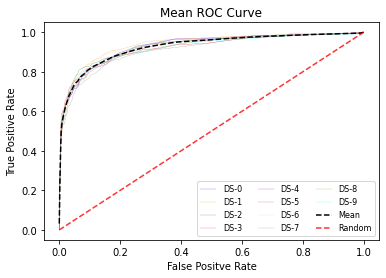

In [8]:
plt.plot(fpr_arr[0],tpr_arr[0],color="blue",linewidth=0.2,label='DS-0')
plt.plot(fpr_arr[1],tpr_arr[1],color="orange",linewidth=0.2,label='DS-1')
plt.plot(fpr_arr[2],tpr_arr[2],color="green",linewidth=0.2,label='DS-2')
plt.plot(fpr_arr[3],tpr_arr[3],color="red",linewidth=0.2,label='DS-3')
plt.plot(fpr_arr[4],tpr_arr[4],color="purple",linewidth=0.2,label='DS-4')
plt.plot(fpr_arr[5],tpr_arr[5],color="brown",linewidth=0.2,label='DS-5')
plt.plot(fpr_arr[6],tpr_arr[6],color="pink",linewidth=0.2,label='DS-6')
plt.plot(fpr_arr[7],tpr_arr[7],color="grey",linewidth=0.2,label='DS-7')
plt.plot(fpr_arr[8],tpr_arr[8],color="olive",linewidth=0.2,label='DS-8')
plt.plot(fpr_arr[9],tpr_arr[9],color="cyan",linewidth=0.2,label='DS-9')


mean_x_axis = [i for i in np.linspace(0,1,500)]
ys_interp = [np.interp(mean_x_axis, fpr_arr[i], tpr_arr[i]) for i in range(len(tpr_arr))]
mean_y_axis = np.mean(ys_interp, axis=0)

#print(ys_interp)

plt.plot(mean_x_axis, mean_y_axis, color="black",linestyle='--',label='Mean')
#plt.show()
plt.title("Mean ROC Curve")
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Random', alpha=.8)
plt.legend(loc='lower right',ncol=3,prop={'size': 8})
plt.savefig('IRWNRLMF_CVS3_ROC.pdf')

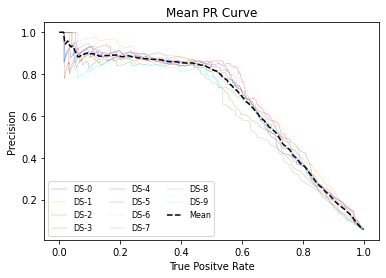

In [10]:
plt.plot(tpr_arr[0],pre_arr[0],color="blue",linewidth=0.2,label='DS-0')
plt.plot(tpr_arr[1],pre_arr[1],color="orange",linewidth=0.2,label='DS-1')
plt.plot(tpr_arr[2],pre_arr[2],color="green",linewidth=0.2,label='DS-2')
plt.plot(tpr_arr[3],pre_arr[3],color="red",linewidth=0.2,label='DS-3')
plt.plot(tpr_arr[4],pre_arr[4],color="purple",linewidth=0.2,label='DS-4')
plt.plot(tpr_arr[5],pre_arr[5],color="brown",linewidth=0.2,label='DS-5')
plt.plot(tpr_arr[6],pre_arr[6],color="pink",linewidth=0.2,label='DS-6')
plt.plot(tpr_arr[7],pre_arr[7],color="grey",linewidth=0.2,label='DS-7')
plt.plot(tpr_arr[8],pre_arr[8],color="olive",linewidth=0.2,label='DS-8')
plt.plot(tpr_arr[9],pre_arr[9],color="cyan",linewidth=0.2,label='DS-9')


mean_x_axis = [i for i in np.linspace(0,1,500)]
ys_interp = [np.interp(mean_x_axis, tpr_arr[i], pre_arr[i]) for i in range(len(tpr_arr))]
mean_y_axis = np.mean(ys_interp, axis=0)

#print(ys_interp)

plt.plot(mean_x_axis, mean_y_axis, color="black",linestyle='--',label='Mean')
#plt.show()
plt.title("Mean PR Curve")
plt.xlabel("True Positve Rate")
plt.ylabel("Precision")

plt.legend(loc='lower left',ncol=3,prop={'size': 8})
plt.savefig('IRWNRLMF_CVS3_PRC.pdf')